

---



# Sound Event Classification 

For this assignment we will be working with the ([**ESC-50**](https://github.com/karolpiczak/ESC-50)) dataset.

In [ ]:
import pandas as pd
import librosa
import os
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchinfo import summary
import IPython.display as ipd

### Checking the Data

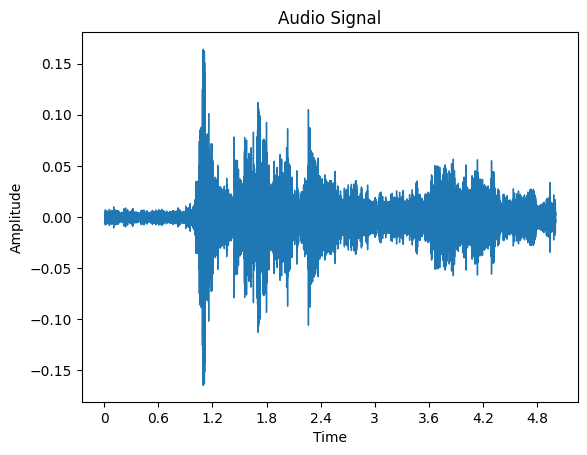

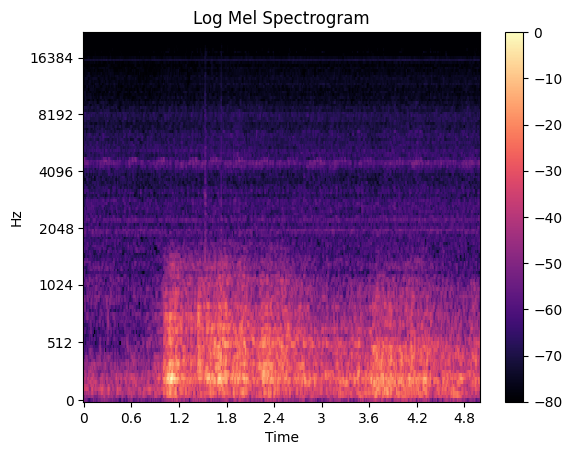

In [ ]:
AUDIO_DIR = "/projects/Machine_Listening/Project_3/ESC-50-master/audio"  
CSV_FILE = "/projects/Machine_Listening/Project_3/ESC-50-master/meta/esc50.csv"  
metadata = pd.read_csv(CSV_FILE)

# Select a sample 
sample_idx = 5
sample_metadata = metadata.iloc[sample_idx]
filename = sample_metadata["filename"]
label = sample_metadata["category"]

# Load the audio file 
audio_path = os.path.join(AUDIO_DIR, filename)
waveform, sample_rate = librosa.load(audio_path, sr=None)  

# Plot the waveform
librosa.display.waveshow(waveform, sr=sample_rate)
plt.title("Audio Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Compute and Plot the Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  

librosa.display.specshow(log_mel_spectrogram, sr=sample_rate, hop_length=512, x_axis="time", y_axis="mel")
plt.colorbar()
plt.title("Log Mel Spectrogram")
plt.show()

# Play the audio
ipd.display(ipd.Audio(audio_path, rate=sample_rate))

### ESC50 Dataloader

In [ ]:
class ESC50Dataset(Dataset):
    def __init__(self, data_dir, data_split, spec_type="log_mel", sr=44100, n_fft=1024, hop_length=512, n_mels=128):
        self.data_dir = data_dir

        dataframe = pd.read_csv(f'{self.data_dir}/meta/esc50.csv')

        if data_split == "train":
            filtered_df = dataframe[dataframe["fold"].isin([1, 2, 3])]
        elif data_split == "val":
            filtered_df = dataframe[dataframe["fold"] == 4]
        elif data_split == "test":
            filtered_df = dataframe[dataframe["fold"] == 5]

        # lists of audio paths and their associated labels from the filtered df
        self.audio_paths = [os.path.join(self.data_dir, "audio", fname) for fname in filtered_df["filename"]]
        self.labels = filtered_df["category"].values

        # All of the spectrogram parameters
        self.spec_type = spec_type
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.sr = sr

        print(f'Number of files in {data_split}: {len(self.audio_paths)}')

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):

        # loading the wavefrom at the specified sample rate
        audio_path = self.audio_paths[idx]
        waveform, sr = librosa.load(audio_path, sr=self.sr)
        
        # the associated label
        label = self.labels[idx]
        
        # given a spectrogram argument self.spec_type, compute the appropriate feature with librosa
        if self.spec_type == "lin_pwr":
            spectrogram = librosa.stft(waveform, n_fft=self.n_fft, hop_length=self.hop_length)
            spectrogram = np.abs(spectrogram) ** 2 
        elif self.spec_type == "log":
            spectrogram = librosa.stft(waveform, n_fft=self.n_fft, hop_length=self.hop_length)
            spectrogram = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)  
        elif self.spec_type == "log_mel":
            mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=self.n_fft,
                                                      hop_length=self.hop_length, n_mels=self.n_mels)
            spectrogram = librosa.power_to_db(mel_spec, ref=np.max)  

        
        # spectrogram normalization
        spectrogram = (spectrogram - spectrogram.mean()) / (spectrogram.std() + 1e-6)
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
        
        return spectrogram, label

In [ ]:
# Instantiate ESC50Dataset class and dataloader
dataset = ESC50Dataset(
    data_dir="/scratch/ne2213/projects/Machine_Listening/Project_3/ESC-50-master",
    data_split="train",  
    spec_type="log_mel",  
    sr=44100,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

print('my dataloader shapes')
for spectrograms, labels in dataloader:
    print(f"Spectrogram batch shape: {spectrograms.shape}")  
    print(f"Labels batch shape: {len(labels)}") 
    print(f"Example labels: {labels}")
    break  # Only show one batch

Number of files in train: 1200
my dataloader shapes
Spectrogram batch shape: torch.Size([8, 128, 431])
Labels batch shape: 8
Example labels: ('clock_tick', 'crickets', 'door_wood_creaks', 'hand_saw', 'train', 'washing_machine', 'chainsaw', 'snoring')


### Two models for sound event classification:

For both models:
- **Model input**: a log-mel spectrogram and it's associated class label (index). Shape: `(batch, 128, 431)` and `(batch,1)`
- **Model output**: a vector of probabilities over the number of classes, that we use to get the predicted sound class. Shape:  `(batch, 50)`

1. **Multi-Layer Perceptron (MLP)**
    - a 2-layer MLP
    - MLP's cannot operate on 2D data, so we will need to flatten the spectrogram input as the first step
    - We use a `relu` activation between the linear layers

2. **Conv-1D**
    - a model with 2 x Conv1D layers followed by a pooling layer, and a final linear layer mapping to the number of output classes. Ideally these convolutional layers will reduce the dimensionality of the spectrogram incrementally.
    - The convolutional layers use `relu` activations after each conv layer

In [ ]:
# MLP classifier class
class MLPClassifier(nn.Module):
    """
    MLP tips:
        - Define a 2-layer MLP
        - MLP's cannot operate on 2D data, so you will need to flatten the spectrogram input as the first step
        - Use a relu activation between your linear layers

    Input Shape: (batch, 128, 431)
    Output Shape: (batch, 50)
    """

    def __init__(self, input_shape=(128, 431), hidden_dim=256, num_classes=50):
        super(MLPClassifier, self).__init__()
        
        # model layers 
        input_dim = input_shape[0] * input_shape[1]
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        
        # Flatten
        x = x.view(x.size(0), -1) 
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)         

        return x

In [ ]:
# Conv1D classifier class
class Conv1DClassifier(nn.Module):
    """
    Conv-1D
        - Define a model with 2 x Conv1D layers followed by a pooling layer, and a final linear layer mapping to the number of output classes.
        - Ideally these convolutional layers will reduce the dimensionality of your spectrogram incrementally.
        - Your convolutional layers should use relu activations after each conv layer
        - Try using BatchNorm1d or Dropout if you are seeing overfitting

    Input Shape: (batch, 128, 431)
    Output Shape: (batch, 50)
    """
    def __init__(self, input_shape=(128, 431), hidden_dim=256, num_classes=50):
        super(Conv1DClassifier, self).__init__()
        
        # model layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[0], out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        conv_output_size = 128 * (input_shape[1] // 4)  
        self.fc1 = nn.Linear(conv_output_size, hidden_dim)
        self.dropout = nn.Dropout(0.3)  
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    

    def forward(self, x):
        
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  

        return x

In [ ]:
from torchinfo import summary
mlp_model = MLPClassifier(input_shape=(128,431), hidden_dim=256, num_classes=50)
summary(mlp_model, input_size=(4,128,431))

Layer (type:depth-idx)                   Output Shape              Param #
MLPClassifier                            [4, 50]                   --
├─Linear: 1-1                            [4, 256]                  14,123,264
├─Linear: 1-2                            [4, 50]                   12,850
Total params: 14,136,114
Trainable params: 14,136,114
Non-trainable params: 0
Total mult-adds (M): 56.54
Input size (MB): 0.88
Forward/backward pass size (MB): 0.01
Params size (MB): 56.54
Estimated Total Size (MB): 57.44

In [ ]:
cnn1_model = Conv1DClassifier(input_shape=(128,431), num_classes=50)
summary(cnn1_model, input_size=(4,128,431))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DClassifier                         [4, 50]                   --
├─Conv1d: 1-1                            [4, 64, 431]              41,024
├─BatchNorm1d: 1-2                       [4, 64, 431]              128
├─MaxPool1d: 1-3                         [4, 64, 215]              --
├─Conv1d: 1-4                            [4, 128, 215]             41,088
├─BatchNorm1d: 1-5                       [4, 128, 215]             256
├─MaxPool1d: 1-6                         [4, 128, 107]             --
├─Linear: 1-7                            [4, 256]                  3,506,432
├─Dropout: 1-8                           [4, 256]                  --
├─Linear: 1-9                            [4, 50]                   12,850
Total params: 3,601,778
Trainable params: 3,601,778
Non-trainable params: 0
Total mult-adds (M): 120.14
Input size (MB): 0.88
Forward/backward pass size (MB): 3.54
Params size (MB): 14.41
Estimated Total 



---



### Architecture Choices 

***MLP:***

- Hidden Dimension 256: a balance between model complexity and computational efficiency
- Activation Function: ReLU is used between layers to introduce non-linearity

***Conv1D:***
- Two convolutional layers with kernel_size=5, stride=1, and padding=2. The kernel_size=5 captures broader frequency/time patterns, and the padding=2 is chosen so that the output width is preserved.
- Pooling layers are added to reduce the spectrogram's time dimension
- Batch Normalization is added after each convolution to improve stability
- Dropout layer is added to help reduce overfitting




---



### Training Script 

In [ ]:
from sklearn.preprocessing import LabelEncoder
def train_and_validate(model_type, device, lr, train_dataloader, val_dataloader, num_epochs):
    """
    Train and validate your MLP or Conv1D models on sound event classification.

    Parameters:
        model_type (str): The type of model to train (e.g., 'mlp', 'conv1d').
        device (str): The device to use for training ('cuda' or 'cpu').
        lr (float): The learning rate for the optimizer.
        train_dataloader (DataLoader): The dataloader for training data.
        val_dataloader (DataLoader): The dataloader for validation data.
        num_epochs (int): The number of epochs to train the model.
    Returns:
        Arrays of training and validation losses and accuracies.
    """

    if model_type == "mlp":
        model = MLPClassifier().to(device)
    elif model_type == "conv1d":
        model = Conv1DClassifier().to(device)


    opt = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss().to(device)

    best_val_accuracy = 0.0
    all_train_loss_epochs = [] 
    all_train_acc_epochs = []
    all_val_loss_epochs = []
    all_val_acc_epochs = []


    for epoch in range(num_epochs):

        total_train_loss = 0.0
        total_correct_train = 0
        total_train_samples = 0
        
        model.train()

        label_encoder = LabelEncoder()
        all_categories = pd.read_csv(f'/projects/Machine_Listening/Project_3/ESC-50-master/meta/esc50.csv')["category"]
        label_encoder.fit(all_categories)  

        for inputs, targets in tqdm(train_dataloader, desc=f"Train Epoch {epoch+1}/{num_epochs}"):

            inputs = inputs.to(device)
                
            targets = label_encoder.transform(targets) 
            targets = torch.tensor(targets, dtype=torch.long, device=device)  

            opt.zero_grad()
            
            outputs = model(inputs)
            
            loss = loss_fn(outputs, targets)
            
            loss.backward()
            
            opt.step()
            
            preds = outputs.argmax(dim=1)  
            total_correct_train += (preds == targets).sum().item()
            total_train_samples += targets.size(0)
            
            total_train_loss += loss.item()
            

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = total_correct_train / total_train_samples
        all_train_loss_epochs.append(avg_train_loss)
        all_train_acc_epochs.append(train_accuracy)

        print(f"Train Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")

        # VALIDATION LOOP
        model.eval()
        
        total_val_loss = 0.0
        total_correct_val = 0
        total_val_samples = 0

        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = label_encoder.transform(targets)
            targets = torch.tensor(targets, dtype=torch.long, device=device)

            outputs = model(inputs)
        
            loss = loss_fn(outputs, targets)
            total_val_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            total_correct_val += (preds == targets).sum().item()
            total_val_samples += targets.size(0)


        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = total_correct_val / total_val_samples
        all_val_loss_epochs.append(avg_val_loss)
        all_val_acc_epochs.append(val_accuracy)
        
        print(f"Validation Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f"best_model_{model_type}.pth")
            print(f"Best model updated with validation accuracy: {best_val_accuracy:.4f}")

    return (all_train_loss_epochs,
            all_train_acc_epochs,
            all_val_loss_epochs,
            all_val_acc_epochs)




---



### Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def load_best_model(model_type, device):
    """
    Load the best saved model from the file system.

    Parameters:
        model_type (str): The type of model to load ('mlp' or 'conv1d').
        device (str): The device to load the model onto ('cuda' or 'cpu').

    Returns:
        model: The loaded model with trained weights.
    """
    if model_type == "mlp":
        model = MLPClassifier().to(device)  
    elif model_type == "conv1d":
        model = Conv1DClassifier().to(device)  

    model.load_state_dict(torch.load(f"best_model_{model_type}.pth", map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded best model: best_model_{model_type}.pth")
    return model


from sklearn.metrics import precision_score, recall_score, f1_score

def eval_model(model, test_dataloader, device):
    """
    Test the loaded model on a test dataset.

    Parameters:
        model: The trained model to evaluate.
        test_dataloader (DataLoader): The dataloader for test data.
        device (str): The device to use for testing ('cuda' or 'cpu').

    Returns:
        results_dict (dict): Dictionary of average acc, precision, recall, and F1 score across all data points.
    """
    model.eval()

    all_preds = []
    all_targets = []

    label_encoder = LabelEncoder()
    all_categories = pd.read_csv(f'/projects/Machine_Listening/Project_3/ESC-50-master/meta/esc50.csv')["category"]
    label_encoder.fit(all_categories)  

    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader, desc="Testing Model"):
            
            inputs = inputs.to(device)
            targets = label_encoder.transform(targets)  
            targets = torch.tensor(targets, dtype=torch.long, device=device)

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)


    results_dict = {
        'avg_acc': accuracy,
        'avg_precision': precision,
        'avg_recall': recall,
        'avg_f1': f1
    }
        
    return results_dict




---



In [ ]:
data_dir = "/projects/Machine_Listening/Project_3/ESC-50-master"  

train_dataset = ESC50Dataset(data_dir=data_dir, data_split="train", spec_type="log_mel")
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ESC50Dataset(data_dir=data_dir, data_split="val", spec_type="log_mel")
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = ESC50Dataset(data_dir=data_dir, data_split="test", spec_type="log_mel")
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu" # see if you have GPU access
print('Device: ', device)


Number of files in train: 1200
Number of files in val: 400
Number of files in test: 400
Device:  cuda


# MLP Training

In [ ]:
tr_loss_ep, tr_acc_ep, val_loss_ep, val_acc_ep = train_and_validate(model_type="mlp",
                                                                    device=device,
                                                                    train_dataloader=train_dataloader,
                                                                    val_dataloader=val_dataloader,
                                                                    num_epochs=50,
                                                                    lr=0.001) 


Train Epoch 1/50: 100%|██████████| 38/38 [00:09<00:00,  4.16it/s]


Train Epoch 1/50, Train Loss: 3.7662, Train Acc: 0.0708


Validation Epoch 1/50: 100%|██████████| 13/13 [00:02<00:00,  4.88it/s]


Validation Epoch 1/50, Validation Loss: 3.5643, Val Accuracy: 0.1150

Best model updated with validation accuracy: 0.1150


Train Epoch 2/50: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s]


Train Epoch 2/50, Train Loss: 3.3724, Train Acc: 0.1967


Validation Epoch 2/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 2/50, Validation Loss: 3.3385, Val Accuracy: 0.1850

Best model updated with validation accuracy: 0.1850


Train Epoch 3/50: 100%|██████████| 38/38 [00:08<00:00,  4.22it/s]


Train Epoch 3/50, Train Loss: 3.0717, Train Acc: 0.2758


Validation Epoch 3/50: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]


Validation Epoch 3/50, Validation Loss: 3.1682, Val Accuracy: 0.1825



Train Epoch 4/50: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s]


Train Epoch 4/50, Train Loss: 2.8279, Train Acc: 0.3275


Validation Epoch 4/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 4/50, Validation Loss: 3.0669, Val Accuracy: 0.2075

Best model updated with validation accuracy: 0.2075


Train Epoch 5/50: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s]


Train Epoch 5/50, Train Loss: 2.6299, Train Acc: 0.3958


Validation Epoch 5/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 5/50, Validation Loss: 2.9698, Val Accuracy: 0.2425

Best model updated with validation accuracy: 0.2425


Train Epoch 6/50: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s]


Train Epoch 6/50, Train Loss: 2.4582, Train Acc: 0.4550


Validation Epoch 6/50: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]


Validation Epoch 6/50, Validation Loss: 2.9058, Val Accuracy: 0.2675

Best model updated with validation accuracy: 0.2675


Train Epoch 7/50: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s]


Train Epoch 7/50, Train Loss: 2.2921, Train Acc: 0.4842


Validation Epoch 7/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 7/50, Validation Loss: 2.8903, Val Accuracy: 0.2500



Train Epoch 8/50: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s]


Train Epoch 8/50, Train Loss: 2.1666, Train Acc: 0.5025


Validation Epoch 8/50: 100%|██████████| 13/13 [00:02<00:00,  4.88it/s]


Validation Epoch 8/50, Validation Loss: 2.8509, Val Accuracy: 0.2300



Train Epoch 9/50: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s]


Train Epoch 9/50, Train Loss: 2.0445, Train Acc: 0.5500


Validation Epoch 9/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 9/50, Validation Loss: 2.8150, Val Accuracy: 0.2750

Best model updated with validation accuracy: 0.2750


Train Epoch 10/50: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s]


Train Epoch 10/50, Train Loss: 1.9362, Train Acc: 0.5925


Validation Epoch 10/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 10/50, Validation Loss: 2.7842, Val Accuracy: 0.2825

Best model updated with validation accuracy: 0.2825


Train Epoch 11/50: 100%|██████████| 38/38 [00:09<00:00,  4.18it/s]


Train Epoch 11/50, Train Loss: 1.8353, Train Acc: 0.6142


Validation Epoch 11/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 11/50, Validation Loss: 2.7825, Val Accuracy: 0.2575



Train Epoch 12/50: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s]


Train Epoch 12/50, Train Loss: 1.7408, Train Acc: 0.6408


Validation Epoch 12/50: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]


Validation Epoch 12/50, Validation Loss: 2.7753, Val Accuracy: 0.2650



Train Epoch 13/50: 100%|██████████| 38/38 [00:08<00:00,  4.22it/s]


Train Epoch 13/50, Train Loss: 1.6620, Train Acc: 0.6617


Validation Epoch 13/50: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]


Validation Epoch 13/50, Validation Loss: 2.7518, Val Accuracy: 0.2775



Train Epoch 14/50: 100%|██████████| 38/38 [00:09<00:00,  4.19it/s]


Train Epoch 14/50, Train Loss: 1.5795, Train Acc: 0.6917


Validation Epoch 14/50: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]


Validation Epoch 14/50, Validation Loss: 2.7603, Val Accuracy: 0.2600



Train Epoch 15/50: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s]


Train Epoch 15/50, Train Loss: 1.5076, Train Acc: 0.6900


Validation Epoch 15/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 15/50, Validation Loss: 2.7266, Val Accuracy: 0.2875

Best model updated with validation accuracy: 0.2875


Train Epoch 16/50: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s]


Train Epoch 16/50, Train Loss: 1.4353, Train Acc: 0.7108


Validation Epoch 16/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 16/50, Validation Loss: 2.7423, Val Accuracy: 0.2825



Train Epoch 17/50: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s]


Train Epoch 17/50, Train Loss: 1.3780, Train Acc: 0.7383


Validation Epoch 17/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 17/50, Validation Loss: 2.7214, Val Accuracy: 0.3100

Best model updated with validation accuracy: 0.3100


Train Epoch 18/50: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s]


Train Epoch 18/50, Train Loss: 1.3167, Train Acc: 0.7508


Validation Epoch 18/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 18/50, Validation Loss: 2.7255, Val Accuracy: 0.2900



Train Epoch 19/50: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s]


Train Epoch 19/50, Train Loss: 1.2504, Train Acc: 0.7725


Validation Epoch 19/50: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]


Validation Epoch 19/50, Validation Loss: 2.7251, Val Accuracy: 0.2850



Train Epoch 20/50: 100%|██████████| 38/38 [00:08<00:00,  4.22it/s]


Train Epoch 20/50, Train Loss: 1.2052, Train Acc: 0.7842


Validation Epoch 20/50: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


Validation Epoch 20/50, Validation Loss: 2.7457, Val Accuracy: 0.2925



Train Epoch 21/50: 100%|██████████| 38/38 [00:08<00:00,  4.43it/s]


Train Epoch 21/50, Train Loss: 1.1558, Train Acc: 0.7942


Validation Epoch 21/50: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


Validation Epoch 21/50, Validation Loss: 2.7205, Val Accuracy: 0.2900



Train Epoch 22/50: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]


Train Epoch 22/50, Train Loss: 1.1123, Train Acc: 0.8050


Validation Epoch 22/50: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]


Validation Epoch 22/50, Validation Loss: 2.7276, Val Accuracy: 0.2975



Train Epoch 23/50: 100%|██████████| 38/38 [00:07<00:00,  4.79it/s]


Train Epoch 23/50, Train Loss: 1.0541, Train Acc: 0.8150


Validation Epoch 23/50: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]


Validation Epoch 23/50, Validation Loss: 2.7162, Val Accuracy: 0.3025



Train Epoch 24/50: 100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


Train Epoch 24/50, Train Loss: 1.0270, Train Acc: 0.8358


Validation Epoch 24/50: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]


Validation Epoch 24/50, Validation Loss: 2.7335, Val Accuracy: 0.3075



Train Epoch 25/50: 100%|██████████| 38/38 [00:07<00:00,  4.79it/s]


Train Epoch 25/50, Train Loss: 0.9789, Train Acc: 0.8392


Validation Epoch 25/50: 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]


Validation Epoch 25/50, Validation Loss: 2.7130, Val Accuracy: 0.2975



Train Epoch 26/50: 100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


Train Epoch 26/50, Train Loss: 0.9493, Train Acc: 0.8475


Validation Epoch 26/50: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]


Validation Epoch 26/50, Validation Loss: 2.7222, Val Accuracy: 0.3025



Train Epoch 27/50: 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]


Train Epoch 27/50, Train Loss: 0.9045, Train Acc: 0.8517


Validation Epoch 27/50: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


Validation Epoch 27/50, Validation Loss: 2.7245, Val Accuracy: 0.2950



Train Epoch 28/50: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]


Train Epoch 28/50, Train Loss: 0.8708, Train Acc: 0.8692


Validation Epoch 28/50: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]


Validation Epoch 28/50, Validation Loss: 2.7300, Val Accuracy: 0.3100



Train Epoch 29/50: 100%|██████████| 38/38 [00:08<00:00,  4.44it/s]


Train Epoch 29/50, Train Loss: 0.8379, Train Acc: 0.8808


Validation Epoch 29/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 29/50, Validation Loss: 2.7490, Val Accuracy: 0.2825



Train Epoch 30/50: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s]


Train Epoch 30/50, Train Loss: 0.8068, Train Acc: 0.8800


Validation Epoch 30/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 30/50, Validation Loss: 2.7458, Val Accuracy: 0.3075



Train Epoch 31/50: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s]


Train Epoch 31/50, Train Loss: 0.7874, Train Acc: 0.8892


Validation Epoch 31/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 31/50, Validation Loss: 2.7887, Val Accuracy: 0.2875



Train Epoch 32/50: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s]


Train Epoch 32/50, Train Loss: 0.7499, Train Acc: 0.8833


Validation Epoch 32/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 32/50, Validation Loss: 2.7407, Val Accuracy: 0.2950



Train Epoch 33/50: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s]


Train Epoch 33/50, Train Loss: 0.7253, Train Acc: 0.9075


Validation Epoch 33/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 33/50, Validation Loss: 2.7603, Val Accuracy: 0.2800



Train Epoch 34/50: 100%|██████████| 38/38 [00:08<00:00,  4.22it/s]


Train Epoch 34/50, Train Loss: 0.7022, Train Acc: 0.9025


Validation Epoch 34/50: 100%|██████████| 13/13 [00:02<00:00,  4.88it/s]


Validation Epoch 34/50, Validation Loss: 2.7708, Val Accuracy: 0.2850



Train Epoch 35/50: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s]


Train Epoch 35/50, Train Loss: 0.6688, Train Acc: 0.9117


Validation Epoch 35/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 35/50, Validation Loss: 2.7544, Val Accuracy: 0.2975



Train Epoch 36/50: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s]


Train Epoch 36/50, Train Loss: 0.6559, Train Acc: 0.9217


Validation Epoch 36/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 36/50, Validation Loss: 2.7584, Val Accuracy: 0.2900



Train Epoch 37/50: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s]


Train Epoch 37/50, Train Loss: 0.6274, Train Acc: 0.9133


Validation Epoch 37/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 37/50, Validation Loss: 2.7407, Val Accuracy: 0.3075



Train Epoch 38/50: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s]


Train Epoch 38/50, Train Loss: 0.6092, Train Acc: 0.9208


Validation Epoch 38/50: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s]


Validation Epoch 38/50, Validation Loss: 2.7815, Val Accuracy: 0.2925



Train Epoch 39/50: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s]


Train Epoch 39/50, Train Loss: 0.5898, Train Acc: 0.9233


Validation Epoch 39/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 39/50, Validation Loss: 2.7503, Val Accuracy: 0.3100



Train Epoch 40/50: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s]


Train Epoch 40/50, Train Loss: 0.5707, Train Acc: 0.9283


Validation Epoch 40/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 40/50, Validation Loss: 2.7521, Val Accuracy: 0.3025



Train Epoch 41/50: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s]


Train Epoch 41/50, Train Loss: 0.5523, Train Acc: 0.9325


Validation Epoch 41/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 41/50, Validation Loss: 2.8235, Val Accuracy: 0.3025



Train Epoch 42/50: 100%|██████████| 38/38 [00:09<00:00,  4.18it/s]


Train Epoch 42/50, Train Loss: 0.5380, Train Acc: 0.9383


Validation Epoch 42/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 42/50, Validation Loss: 2.7488, Val Accuracy: 0.3125

Best model updated with validation accuracy: 0.3125


Train Epoch 43/50: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s]


Train Epoch 43/50, Train Loss: 0.5126, Train Acc: 0.9408


Validation Epoch 43/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 43/50, Validation Loss: 2.7920, Val Accuracy: 0.2875



Train Epoch 44/50: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s]


Train Epoch 44/50, Train Loss: 0.5020, Train Acc: 0.9425


Validation Epoch 44/50: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


Validation Epoch 44/50, Validation Loss: 2.8434, Val Accuracy: 0.2725



Train Epoch 45/50: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s]


Train Epoch 45/50, Train Loss: 0.4882, Train Acc: 0.9425


Validation Epoch 45/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 45/50, Validation Loss: 2.7744, Val Accuracy: 0.3150

Best model updated with validation accuracy: 0.3150


Train Epoch 46/50: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s]


Train Epoch 46/50, Train Loss: 0.4738, Train Acc: 0.9508


Validation Epoch 46/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 46/50, Validation Loss: 2.8759, Val Accuracy: 0.2825



Train Epoch 47/50: 100%|██████████| 38/38 [00:08<00:00,  4.22it/s]


Train Epoch 47/50, Train Loss: 0.4566, Train Acc: 0.9608


Validation Epoch 47/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 47/50, Validation Loss: 2.7639, Val Accuracy: 0.2975



Train Epoch 48/50: 100%|██████████| 38/38 [00:08<00:00,  4.23it/s]


Train Epoch 48/50, Train Loss: 0.4463, Train Acc: 0.9533


Validation Epoch 48/50: 100%|██████████| 13/13 [00:02<00:00,  4.95it/s]


Validation Epoch 48/50, Validation Loss: 2.7908, Val Accuracy: 0.3000



Train Epoch 49/50: 100%|██████████| 38/38 [00:08<00:00,  4.39it/s]


Train Epoch 49/50, Train Loss: 0.4354, Train Acc: 0.9608


Validation Epoch 49/50: 100%|██████████| 13/13 [00:02<00:00,  4.37it/s]


Validation Epoch 49/50, Validation Loss: 2.7977, Val Accuracy: 0.3075



Train Epoch 50/50: 100%|██████████| 38/38 [00:08<00:00,  4.59it/s]


Train Epoch 50/50, Train Loss: 0.4147, Train Acc: 0.9633


Validation Epoch 50/50: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s]

Validation Epoch 50/50, Validation Loss: 2.7969, Val Accuracy: 0.2950



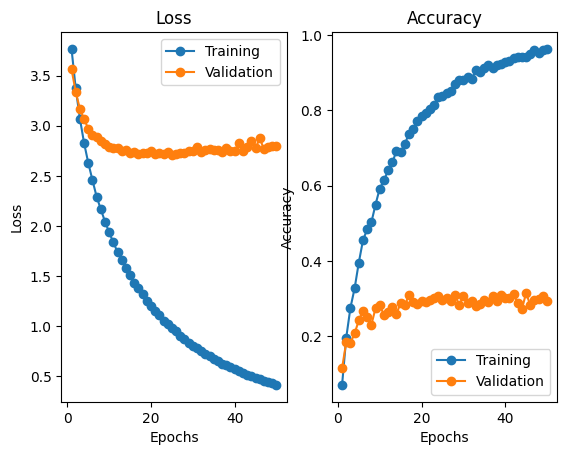

In [ ]:
# Plotting
num_epochs=50
epochs = range(1, num_epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss_ep, label='Training', marker='o')
plt.plot(epochs, val_loss_ep, label='Validation', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc_ep, label='Training', marker='o')
plt.plot(epochs, val_acc_ep, label='Validation', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


In [ ]:
trained_model_mlp = load_best_model("mlp", device)
trained_model_mlp.eval()
results_mlp = eval_model(trained_model_mlp, test_dataloader, device)
print(results_mlp)

Loaded best model: best_model_mlp.pth


Testing Model: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]

{'avg_acc': 0.29, 'avg_precision': 0.28353022708285863, 'avg_recall': 0.29, 'avg_f1': 0.2688879593482501}




---



### Conv1D Training

In [ ]:
tr_loss_ep, tr_acc_ep, val_loss_ep, val_acc_ep = train_and_validate(model_type="conv1d",
                                                                    device=device,
                                                                    train_dataloader=train_dataloader,
                                                                    val_dataloader=val_dataloader,
                                                                    num_epochs=50,
                                                                    lr=0.1) # I found LR=0.1 to work well for conv1d here (but depends on your model)

Train Epoch 1/50: 100%|██████████| 38/38 [00:10<00:00,  3.78it/s]


Train Epoch 1/50, Train Loss: 3.8383, Train Acc: 0.0683


Validation Epoch 1/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 1/50, Validation Loss: 3.7831, Val Accuracy: 0.0400

Best model updated with validation accuracy: 0.0400


Train Epoch 2/50: 100%|██████████| 38/38 [00:09<00:00,  4.19it/s]


Train Epoch 2/50, Train Loss: 3.5333, Train Acc: 0.0967


Validation Epoch 2/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 2/50, Validation Loss: 3.4547, Val Accuracy: 0.0875

Best model updated with validation accuracy: 0.0875


Train Epoch 3/50: 100%|██████████| 38/38 [00:09<00:00,  4.19it/s]


Train Epoch 3/50, Train Loss: 3.3989, Train Acc: 0.1175


Validation Epoch 3/50: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s]


Validation Epoch 3/50, Validation Loss: 3.2886, Val Accuracy: 0.1050

Best model updated with validation accuracy: 0.1050


Train Epoch 4/50: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s]


Train Epoch 4/50, Train Loss: 3.1527, Train Acc: 0.1433


Validation Epoch 4/50: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


Validation Epoch 4/50, Validation Loss: 3.4081, Val Accuracy: 0.1500

Best model updated with validation accuracy: 0.1500


Train Epoch 5/50: 100%|██████████| 38/38 [00:09<00:00,  4.19it/s]


Train Epoch 5/50, Train Loss: 3.0233, Train Acc: 0.1850


Validation Epoch 5/50: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]


Validation Epoch 5/50, Validation Loss: 3.1838, Val Accuracy: 0.1725

Best model updated with validation accuracy: 0.1725


Train Epoch 6/50: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s]


Train Epoch 6/50, Train Loss: 2.8553, Train Acc: 0.2175


Validation Epoch 6/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]


Validation Epoch 6/50, Validation Loss: 3.4266, Val Accuracy: 0.1475



Train Epoch 7/50: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s]


Train Epoch 7/50, Train Loss: 2.6251, Train Acc: 0.2550


Validation Epoch 7/50: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]


Validation Epoch 7/50, Validation Loss: 2.8472, Val Accuracy: 0.2400

Best model updated with validation accuracy: 0.2400


Train Epoch 8/50: 100%|██████████| 38/38 [00:09<00:00,  4.18it/s]


Train Epoch 8/50, Train Loss: 2.4898, Train Acc: 0.2950


Validation Epoch 8/50: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]


Validation Epoch 8/50, Validation Loss: 2.9102, Val Accuracy: 0.2350



Train Epoch 9/50: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s]


Train Epoch 9/50, Train Loss: 2.3518, Train Acc: 0.3200


Validation Epoch 9/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 9/50, Validation Loss: 2.8471, Val Accuracy: 0.2375



Train Epoch 10/50: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s]


Train Epoch 10/50, Train Loss: 2.2068, Train Acc: 0.3817


Validation Epoch 10/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 10/50, Validation Loss: 2.7328, Val Accuracy: 0.2475

Best model updated with validation accuracy: 0.2475


Train Epoch 11/50: 100%|██████████| 38/38 [00:09<00:00,  4.16it/s]


Train Epoch 11/50, Train Loss: 1.9090, Train Acc: 0.4258


Validation Epoch 11/50: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


Validation Epoch 11/50, Validation Loss: 2.7166, Val Accuracy: 0.3350

Best model updated with validation accuracy: 0.3350


Train Epoch 12/50: 100%|██████████| 38/38 [00:09<00:00,  4.19it/s]


Train Epoch 12/50, Train Loss: 1.7899, Train Acc: 0.4583


Validation Epoch 12/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 12/50, Validation Loss: 2.7855, Val Accuracy: 0.3075



Train Epoch 13/50: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s]


Train Epoch 13/50, Train Loss: 1.6883, Train Acc: 0.4933


Validation Epoch 13/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 13/50, Validation Loss: 2.8908, Val Accuracy: 0.3100



Train Epoch 14/50: 100%|██████████| 38/38 [00:09<00:00,  4.19it/s]


Train Epoch 14/50, Train Loss: 1.5446, Train Acc: 0.5358


Validation Epoch 14/50: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]


Validation Epoch 14/50, Validation Loss: 3.0903, Val Accuracy: 0.3100



Train Epoch 15/50: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s]


Train Epoch 15/50, Train Loss: 1.4348, Train Acc: 0.5617


Validation Epoch 15/50: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]


Validation Epoch 15/50, Validation Loss: 3.2138, Val Accuracy: 0.2550



Train Epoch 16/50: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s]


Train Epoch 16/50, Train Loss: 1.2375, Train Acc: 0.6067


Validation Epoch 16/50: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]


Validation Epoch 16/50, Validation Loss: 2.7989, Val Accuracy: 0.3300



Train Epoch 17/50: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s]


Train Epoch 17/50, Train Loss: 1.2196, Train Acc: 0.6200


Validation Epoch 17/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 17/50, Validation Loss: 3.3849, Val Accuracy: 0.2950



Train Epoch 18/50: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s]


Train Epoch 18/50, Train Loss: 1.0389, Train Acc: 0.6825


Validation Epoch 18/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 18/50, Validation Loss: 3.1631, Val Accuracy: 0.3550

Best model updated with validation accuracy: 0.3550


Train Epoch 19/50: 100%|██████████| 38/38 [00:09<00:00,  4.19it/s]


Train Epoch 19/50, Train Loss: 1.0447, Train Acc: 0.6733


Validation Epoch 19/50: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]


Validation Epoch 19/50, Validation Loss: 2.7447, Val Accuracy: 0.3750

Best model updated with validation accuracy: 0.3750


Train Epoch 20/50: 100%|██████████| 38/38 [00:09<00:00,  4.19it/s]


Train Epoch 20/50, Train Loss: 0.9071, Train Acc: 0.7083


Validation Epoch 20/50: 100%|██████████| 13/13 [00:02<00:00,  4.85it/s]


Validation Epoch 20/50, Validation Loss: 3.0991, Val Accuracy: 0.3300



Train Epoch 21/50: 100%|██████████| 38/38 [00:09<00:00,  4.15it/s]


Train Epoch 21/50, Train Loss: 0.8495, Train Acc: 0.7408


Validation Epoch 21/50: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s]


Validation Epoch 21/50, Validation Loss: 2.9824, Val Accuracy: 0.3600



Train Epoch 22/50: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s]


Train Epoch 22/50, Train Loss: 0.7445, Train Acc: 0.7742


Validation Epoch 22/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 22/50, Validation Loss: 3.1513, Val Accuracy: 0.3625



Train Epoch 23/50: 100%|██████████| 38/38 [00:09<00:00,  4.21it/s]


Train Epoch 23/50, Train Loss: 0.7242, Train Acc: 0.7658


Validation Epoch 23/50: 100%|██████████| 13/13 [00:02<00:00,  4.85it/s]


Validation Epoch 23/50, Validation Loss: 3.4988, Val Accuracy: 0.3275



Train Epoch 24/50: 100%|██████████| 38/38 [00:08<00:00,  4.32it/s]


Train Epoch 24/50, Train Loss: 0.7444, Train Acc: 0.7658


Validation Epoch 24/50: 100%|██████████| 13/13 [00:02<00:00,  4.41it/s]


Validation Epoch 24/50, Validation Loss: 3.2613, Val Accuracy: 0.3425



Train Epoch 25/50: 100%|██████████| 38/38 [00:08<00:00,  4.52it/s]


Train Epoch 25/50, Train Loss: 0.6192, Train Acc: 0.8100


Validation Epoch 25/50: 100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Validation Epoch 25/50, Validation Loss: 4.1021, Val Accuracy: 0.3175



Train Epoch 26/50: 100%|██████████| 38/38 [00:08<00:00,  4.75it/s]


Train Epoch 26/50, Train Loss: 0.6294, Train Acc: 0.7958


Validation Epoch 26/50: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]


Validation Epoch 26/50, Validation Loss: 3.2521, Val Accuracy: 0.3725



Train Epoch 27/50: 100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


Train Epoch 27/50, Train Loss: 0.5720, Train Acc: 0.8275


Validation Epoch 27/50: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]


Validation Epoch 27/50, Validation Loss: 3.0664, Val Accuracy: 0.3725



Train Epoch 28/50: 100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


Train Epoch 28/50, Train Loss: 0.5217, Train Acc: 0.8275


Validation Epoch 28/50: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]


Validation Epoch 28/50, Validation Loss: 3.1513, Val Accuracy: 0.3975

Best model updated with validation accuracy: 0.3975


Train Epoch 29/50: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]


Train Epoch 29/50, Train Loss: 0.4851, Train Acc: 0.8442


Validation Epoch 29/50: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]


Validation Epoch 29/50, Validation Loss: 3.2549, Val Accuracy: 0.3625



Train Epoch 30/50: 100%|██████████| 38/38 [00:07<00:00,  4.75it/s]


Train Epoch 30/50, Train Loss: 0.4466, Train Acc: 0.8533


Validation Epoch 30/50: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]


Validation Epoch 30/50, Validation Loss: 3.0632, Val Accuracy: 0.4075

Best model updated with validation accuracy: 0.4075


Train Epoch 31/50: 100%|██████████| 38/38 [00:07<00:00,  4.75it/s]


Train Epoch 31/50, Train Loss: 0.4458, Train Acc: 0.8692


Validation Epoch 31/50: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Validation Epoch 31/50, Validation Loss: 2.9142, Val Accuracy: 0.4100

Best model updated with validation accuracy: 0.4100


Train Epoch 32/50: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]


Train Epoch 32/50, Train Loss: 0.4144, Train Acc: 0.8633


Validation Epoch 32/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 32/50, Validation Loss: 4.2742, Val Accuracy: 0.3400



Train Epoch 33/50: 100%|██████████| 38/38 [00:07<00:00,  4.75it/s]


Train Epoch 33/50, Train Loss: 0.4132, Train Acc: 0.8633


Validation Epoch 33/50: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


Validation Epoch 33/50, Validation Loss: 3.6251, Val Accuracy: 0.3675



Train Epoch 34/50: 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]


Train Epoch 34/50, Train Loss: 0.3639, Train Acc: 0.8783


Validation Epoch 34/50: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]


Validation Epoch 34/50, Validation Loss: 3.2727, Val Accuracy: 0.3875



Train Epoch 35/50: 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]


Train Epoch 35/50, Train Loss: 0.2805, Train Acc: 0.9108


Validation Epoch 35/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 35/50, Validation Loss: 3.6562, Val Accuracy: 0.3900



Train Epoch 36/50: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]


Train Epoch 36/50, Train Loss: 0.2878, Train Acc: 0.9208


Validation Epoch 36/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 36/50, Validation Loss: 3.4578, Val Accuracy: 0.3925



Train Epoch 37/50: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]


Train Epoch 37/50, Train Loss: 0.2805, Train Acc: 0.9175


Validation Epoch 37/50: 100%|██████████| 13/13 [00:02<00:00,  4.87it/s]


Validation Epoch 37/50, Validation Loss: 3.7125, Val Accuracy: 0.3800



Train Epoch 38/50: 100%|██████████| 38/38 [00:08<00:00,  4.75it/s]


Train Epoch 38/50, Train Loss: 0.2986, Train Acc: 0.9017


Validation Epoch 38/50: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]


Validation Epoch 38/50, Validation Loss: 3.3792, Val Accuracy: 0.3950



Train Epoch 39/50: 100%|██████████| 38/38 [00:08<00:00,  4.75it/s]


Train Epoch 39/50, Train Loss: 0.2698, Train Acc: 0.9125


Validation Epoch 39/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 39/50, Validation Loss: 3.4930, Val Accuracy: 0.3850



Train Epoch 40/50: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]


Train Epoch 40/50, Train Loss: 0.3046, Train Acc: 0.9033


Validation Epoch 40/50: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


Validation Epoch 40/50, Validation Loss: 3.2790, Val Accuracy: 0.4200

Best model updated with validation accuracy: 0.4200


Train Epoch 41/50: 100%|██████████| 38/38 [00:07<00:00,  4.75it/s]


Train Epoch 41/50, Train Loss: 0.2519, Train Acc: 0.9167


Validation Epoch 41/50: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


Validation Epoch 41/50, Validation Loss: 3.2804, Val Accuracy: 0.3875



Train Epoch 42/50: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]


Train Epoch 42/50, Train Loss: 0.2081, Train Acc: 0.9283


Validation Epoch 42/50: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


Validation Epoch 42/50, Validation Loss: 3.2567, Val Accuracy: 0.4100



Train Epoch 43/50: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]


Train Epoch 43/50, Train Loss: 0.2188, Train Acc: 0.9417


Validation Epoch 43/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 43/50, Validation Loss: 3.4576, Val Accuracy: 0.3700



Train Epoch 44/50: 100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


Train Epoch 44/50, Train Loss: 0.2211, Train Acc: 0.9342


Validation Epoch 44/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 44/50, Validation Loss: 3.6564, Val Accuracy: 0.3950



Train Epoch 45/50: 100%|██████████| 38/38 [00:07<00:00,  4.75it/s]


Train Epoch 45/50, Train Loss: 0.2129, Train Acc: 0.9275


Validation Epoch 45/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 45/50, Validation Loss: 3.2878, Val Accuracy: 0.4100



Train Epoch 46/50: 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]


Train Epoch 46/50, Train Loss: 0.1911, Train Acc: 0.9350


Validation Epoch 46/50: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Validation Epoch 46/50, Validation Loss: 3.3696, Val Accuracy: 0.4300

Best model updated with validation accuracy: 0.4300


Train Epoch 47/50: 100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


Train Epoch 47/50, Train Loss: 0.1871, Train Acc: 0.9425


Validation Epoch 47/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 47/50, Validation Loss: 3.4333, Val Accuracy: 0.4025



Train Epoch 48/50: 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]


Train Epoch 48/50, Train Loss: 0.1767, Train Acc: 0.9358


Validation Epoch 48/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 48/50, Validation Loss: 3.4119, Val Accuracy: 0.4350

Best model updated with validation accuracy: 0.4350


Train Epoch 49/50: 100%|██████████| 38/38 [00:07<00:00,  4.75it/s]


Train Epoch 49/50, Train Loss: 0.1388, Train Acc: 0.9600


Validation Epoch 49/50: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Validation Epoch 49/50, Validation Loss: 3.3423, Val Accuracy: 0.4250



Train Epoch 50/50: 100%|██████████| 38/38 [00:07<00:00,  4.75it/s]


Train Epoch 50/50, Train Loss: 0.1600, Train Acc: 0.9517


Validation Epoch 50/50: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]

Validation Epoch 50/50, Validation Loss: 3.5061, Val Accuracy: 0.4000



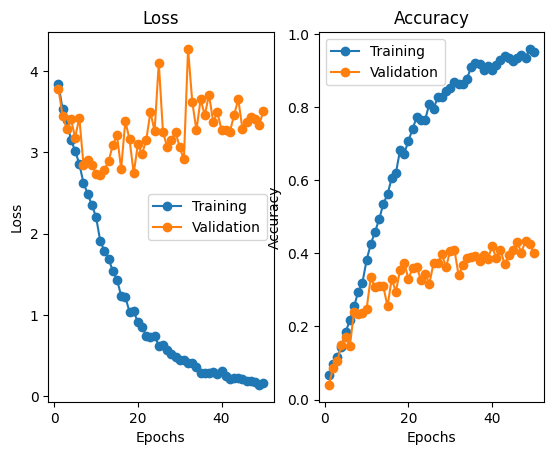

In [ ]:
# Plotting

num_epochs=50
epochs = range(1, num_epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss_ep, label='Training', marker='o')
plt.plot(epochs, val_loss_ep, label='Validation', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc_ep, label='Training', marker='o')
plt.plot(epochs, val_acc_ep, label='Validation', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


#### Test your Conv1D

In [ ]:
trained_model_conv = load_best_model("conv1d", device)
trained_model_conv.eval()
results_conv = eval_model(trained_model_conv, test_dataloader, device)
print(results_conv)

Loaded best model: best_model_conv1d.pth


Testing Model: 100%|██████████| 13/13 [00:03<00:00,  3.65it/s]

{'avg_acc': 0.35, 'avg_precision': 0.3968141025641026, 'avg_recall': 0.35, 'avg_f1': 0.34291024065448616}




---



From the results, we can see that Conv1D outperforms MLP in every metric (accuracy, precision, recall, and f1 score). This means that Conv1D captures spatial and temporal patterns in the data better. This is expected because Conv1D is designed for sequential data (which means it learns local patterns better), but MLP treats all input features independently. 

**MLP:** We see that training loss decreases, but validation loss doesn't change much. Also, training accuracy almost reaches 1, but validation accuracy stays at around 0.3, which means the model is overfitting and doesn't generalize well.

**Conv1D:** We see that training loss is also decreasing here, but validation loss has a lot of fluctuations, and is a lot worse compared to training loss. However, the overall validation accuracy is slightly better than the MLP model.



---

